## Poisson Equation in 2D

In this example we solve the Poisson equation in two space dimensions.

For a domain $\Omega \subset \mathbb{R}^2$ with boundary $\partial \Omega = \Gamma_D \cup \Gamma_N$, we write the boundary value problem (BVP):

$$ 
\left\{
\begin{array}{ll}
- \Delta u = f  & \text{in} \; \Omega, \\
u = u_D & \text{on} \; \Gamma_D, \\
\nabla u \cdot \boldsymbol{n} = g & \text{on} \; \Gamma_N.
\end{array}
\right.$$

Here, $\Gamma_D \subset \Omega$ denotes the part of the boundary where we prescribe Dirichlet boundary conditions, and $\Gamma_N \subset \Omega$ denotes the part of the boundary where we prescribe Neumann boundary conditions. $\boldsymbol{n}$ denotes the unit normal of $\partial \Omega$ pointing outside $\Omega$. 

To obtain the weak form we define the functional spaces $V_{u_D} := \left\{ u \in H^1(\Omega) \, |\, u = u_D \text{ on } \Gamma_D \right\}$ and $V_{0} := \left\{ u \in H^1(\Omega) \, |\, u = 0 \text{ on } \Gamma_D \right\}$.
Then we multiply the strong form by an arbitrary function $v \in V_0$ and integrate over $\Omega$:

$$ - \int_\Omega \Delta u \, v \, dx = \int_\Omega f\,v \, dx, \quad \forall v \in V_0. $$

Integration by parts of the non-conforming term gives

$$ - \int_\Omega \Delta u \, v \, dx = \int_\Omega \nabla u \cdot \nabla v \, dx - \int_{\partial\Omega} (\nabla u \cdot \boldsymbol{n}) \,v\, ds $$

Recalling that $v = 0$ on $\Gamma_D$ and that $\nabla u \cdot \boldsymbol{n} = g$ on $\Gamma_N$, the weak form of the BVP is the following.

Find $u \in V_{u_D}$:
$$ \int_\Omega \nabla u \cdot \nabla v \, dx = \int_\Omega f\,v \, dx + \int_{\Gamma_N} g\,v\,ds, \quad \forall v \in V_0. $$

To obtain the finite element discretization we then introduce a triangulation (mesh) $\mathcal{T}_h$ of the domain $\Omega$ and we define a finite dimensional subspace $V_h \subset H^1(\Omega)$ consisting of globally continuous functions that are piecewise polynomial on each element of $\mathcal{T}_h$.

By letting $V_{h, u_D} := \{ v_h \in V_h \,|\, v_h = u_D \text{ on } \Gamma_D\}$ and $V_{h, 0} := \{ v_h \in V_h \,|\, v_h = 0 \text{ on } \Gamma_D\}$, the finite element method then reads:

Find $u_h \in V_{h, u_D}$ such that:
$$ \int_\Omega \nabla u_h \cdot \nabla v_h \, dx = \int_\Omega f\,v_h \, dx + \int_{\Gamma_N} g\,v_h\,ds, \quad \forall v_h \in V_{h,0}. $$

In what follow, we will let $\Omega := [0,1]\times[0,1]$ be the unit square, $\Gamma_N := \{ (x,y) \in \partial\Omega \,|\, y = 1\}$ be the top boundary, and $\Gamma_D := \partial\Omega \setminus \Gamma_N$ be the union of the left, bottom, and right boundaries.

The coefficient $f$, $g$, $u_D$ are chosen such that the analytical solution is $u_{ex} = e^{\pi y} \sin(\pi x)$.


### 1. Imports
We import the following Python packages:

- `dolfin` is the python interface to FEniCS.
- `matplotlib` is a plotting library that produces figure similar to the Matlab ones.
- `math` is the python built-in library of mathematical functions.

In [1]:
from __future__ import print_function, absolute_import, division

# Import FEniCS
import dolfin as dl
import math

# Enable plotting inside the notebook
import matplotlib.pyplot as plt
%matplotlib inline

from hippylib import nb

import logging
logging.getLogger('FFC').setLevel(logging.WARNING)
logging.getLogger('UFL').setLevel(logging.WARNING)
dl.set_log_active(False)

### 2. Define the mesh and the finite element space
We define a triangulation (mesh) of the unit square $\Omega = [0,1]\times[0,1]$ with `n` elements in each direction. The mesh size $h$ is $\frac{1}{n}$.

We also define the finite element space $V_h$ as the space of globally continuos functions that are piecewise polinomial (of degree $d$) on the elements of the mesh.

Number of dofs 4225


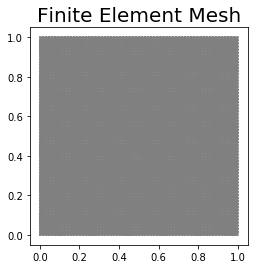

In [2]:
n = 64
d = 1
mesh = dl.UnitSquareMesh(n, n)
Vh = dl.FunctionSpace(mesh, "Lagrange", d)
print("Number of dofs", Vh.dim())
nb.plot(mesh, mytitle="Finite Element Mesh", show_axis='on')
plt.show()

### 3. Define the Dirichlet boundary condition

We define the Dirichlet boundary condition $u = u_d := \sin(\pi x)$ on $\Gamma_D$.

In [3]:
def boundary_d(x, on_boundary):
    return (x[1] < dl.DOLFIN_EPS or x[0] < dl.DOLFIN_EPS or x[0] > 1.0 - dl.DOLFIN_EPS) and on_boundary

u_d  = dl.Expression("sin(DOLFIN_PI*x[0])", degree = d+2)
bcs = [dl.DirichletBC(Vh, u_d, boundary_d)]

### 4. Define the variational problem

We write the variational problem $a(u_h, v_h) = F(v_h)$. Here, the bilinear form $a$ and the linear form $L$ are defined as

- $a(u_h, v_h) := \int_\Omega \nabla u_h \cdot \nabla v_h \, dx$
- $L(v_h) := \int_\Omega f v_h \, dx + \int_{\Gamma_N} g \, v_h \, dx$.

$u_h$ denotes the trial function and $v_h$ denotes the test function.  The coefficients $f = 0$ and $g = \pi\, e^{\pi y} \sin( \pi x) $ are also given.

In [4]:
uh = dl.TrialFunction(Vh)
vh = dl.TestFunction(Vh)

f = dl.Constant(0.)
g = dl.Expression("DOLFIN_PI*exp(DOLFIN_PI*x[1])*sin(DOLFIN_PI*x[0])", degree=d+2)
a = dl.inner(dl.grad(uh), dl.grad(vh))*dl.dx
L = f*vh*dl.dx + g*vh*dl.ds

### 5. Assemble and solve the finite element discrete problem

We now assemble the finite element stiffness matrix $A$ and the right hand side vector $b$. Dirichlet boundary conditions are applied at the end of the finite element assembly procedure and before solving the resulting linear system of equations.

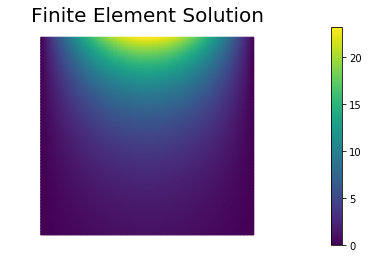

In [5]:
A, b = dl.assemble_system(a, L, bcs)
uh = dl.Function(Vh)
dl.solve(A, uh.vector(), b)

nb.plot(uh, mytitle="Finite Element Solution")
plt.show()

### 6. Compute error norms

We then compute the $L^2(\Omega)$ and the energy norm of the difference between the exact solution and the finite element approximation.

In [6]:
u_ex = dl.Expression("exp(DOLFIN_PI*x[1])*sin(DOLFIN_PI*x[0])", degree = d+2, domain=mesh)
grad_u_ex = dl.Expression( ("DOLFIN_PI*exp(DOLFIN_PI*x[1])*cos(DOLFIN_PI*x[0])",
                         "DOLFIN_PI*exp(DOLFIN_PI*x[1])*sin(DOLFIN_PI*x[0])"), degree = d+2, domain=mesh )

norm_u_ex   = math.sqrt(dl.assemble(u_ex**2*dl.dx))
norm_grad_ex = math.sqrt(dl.assemble(dl.inner(grad_u_ex, grad_u_ex)*dl.dx))

err_L2   = math.sqrt(dl.assemble((uh - u_ex)**2*dl.dx))
err_grad = math.sqrt(dl.assemble(dl.inner(dl.grad(uh) - grad_u_ex, dl.grad(uh) - grad_u_ex)*dl.dx))

print ("|| u_ex - u_h ||_L2 / || u_ex ||_L2 = ", err_L2/norm_u_ex)
print ("|| grad(u_ex - u_h)||_L2 / = || grad(u_ex)||_L2 ", err_grad/norm_grad_ex)

|| u_ex - u_h ||_L2 / || u_ex ||_L2 =  0.0004267539774457824
|| grad(u_ex - u_h)||_L2 / = || grad(u_ex)||_L2  0.02453704048509311


## Hands on: Advection-Diffusion-Reaction PDEs

For a bounded domain $\Omega \subset \mathbb{R}^2$ with boundary $\partial \Omega = \Gamma_D \cup \Gamma_N$, consider the boundary value problem

$$ 
\left\{
\begin{array}{ll}
- \nabla \cdot(k \nabla u) + \boldsymbol{w} \cdot \nabla u + c u = f  & \text{in} \; \Omega, \\
u = u_D & \text{on} \; \Gamma_D, \\
k \nabla u \cdot \boldsymbol{n} = g & \text{on} \; \Gamma_N.
\end{array}
\right.$$

Here, $\Gamma_D \subset \Omega$ denotes the part of the boundary where we prescribe Dirichlet boundary conditions, and $\Gamma_N \subset \Omega$ denotes the part of the boundary where we prescribe Neumann boundary conditions. $\boldsymbol{n}$ denotes the unit normal of $\partial \Omega$ pointing outside $\Omega$.

### Question 1
> Derive the weak formulation of the above boundary value problem.

To derive the weak form, we first define the function spaces $V_{u_D}$ and $V_0$ subspaces of $H^1(\Omega)$ associated with the inhomogeneuos and homogeneuos form of the Dirichlet boundary condition:

$$ V_{u_D} = \{ v \in H^1(\Omega) \, | \, v = u_D \text{ on } \Gamma_D \}, \text{ and }
V_{0} = \{ v \in H^1(\Omega) \, | \, v = 0 \text{ on } \Gamma_D \}.$$

Then we multiply the strong form by an arbitrary function $v \in V_0$ and integrate over $\Omega$:

$$ - \int_\Omega v\, \left(- \nabla \cdot(k \nabla u) + \boldsymbol{v} \cdot \nabla u + c u \right) dx = \int_\Omega f\,v \, dx, \quad \forall v \in V_0. $$

Integration by parts of the non-conforming term gives

$$ - \int_\Omega v \,\nabla \cdot(k \nabla u)\, dx = \int_\Omega k \, \nabla u \cdot \nabla v \, dx - \int_{\partial\Omega} (k \nabla u \cdot \boldsymbol{n}) \,v\, ds $$

Recalling that $v = 0$ on $\Gamma_D$ and that $k \nabla u \cdot \boldsymbol{n} = g$ on $\Gamma_N$, the weak form of the BVP is the following.

Find $u \in V_{u_D}$:
$$ \int_\Omega k \nabla u \cdot \nabla v \, dx + \int_\Omega \boldsymbol{w}\cdot \nabla u \, v\,dx + \int_\Omega c\, u\, v\, dx = \int_\Omega f\,v \, dx + \int_{\Gamma_N} g\,v\,ds, \quad \forall v \in V_0. $$


### Question 2
> Compute the finite element solution of the above problem using FEniCS with $k = k(\boldsymbol{x}) = e^{-\|\boldsymbol{x}\|^2}$, $\boldsymbol{w} = [0,1]^t$, $c=1$, $f = 1$, $u_D = 0$, $g=0$. Choose $\Omega$, $\Gamma_N$, and $\Gamma_D$ as in the example above.

Number of dofs 4225


--- Instant: compiling ---


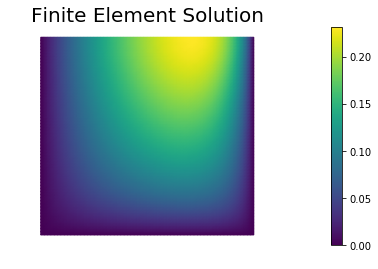

In [7]:
n = 64
d = 1
mesh = dl.UnitSquareMesh(n, n)
Vh = dl.FunctionSpace(mesh, "Lagrange", d)
print("Number of dofs", Vh.dim())

def boundary_d(x, on_boundary):
    return (x[1] < dl.DOLFIN_EPS or x[0] < dl.DOLFIN_EPS or x[0] > 1.0 - dl.DOLFIN_EPS) and on_boundary

u_d  = dl.Constant(0.)
bcs = [dl.DirichletBC(Vh, u_d, boundary_d)]

uh = dl.TrialFunction(Vh)
vh = dl.TestFunction(Vh)

k = dl.Expression("exp(-x[0]*x[0] -x[1]*x[1])", degree = d+2)
w = dl.Constant( (1.,0.))
c = dl.Constant(1.)

f = dl.Constant(1.)
g = dl.Constant(0.)
a = k*dl.inner(dl.grad(uh), dl.grad(vh))*dl.dx + dl.dot(w, dl.grad(uh))*vh*dl.dx + c*uh*vh*dl.dx
L = f*vh*dl.dx + g*vh*dl.ds

A, b = dl.assemble_system(a, L, bcs)
uh = dl.Function(Vh)
dl.solve(A, uh.vector(), b)

nb.plot(uh, mytitle="Finite Element Solution")
plt.show()

Copyright &copy; 2018, The University of Texas at Austin & University of California, Merced. All Rights reserved. See file COPYRIGHT for details.

This file is part of the hIPPYlib library. For more information and source code availability see https://hippylib.github.io.

hIPPYlib is free software; you can redistribute it and/or modify it under the terms of the GNU General Public License (as published by the Free Software Foundation) version 2.0 dated June 1991.